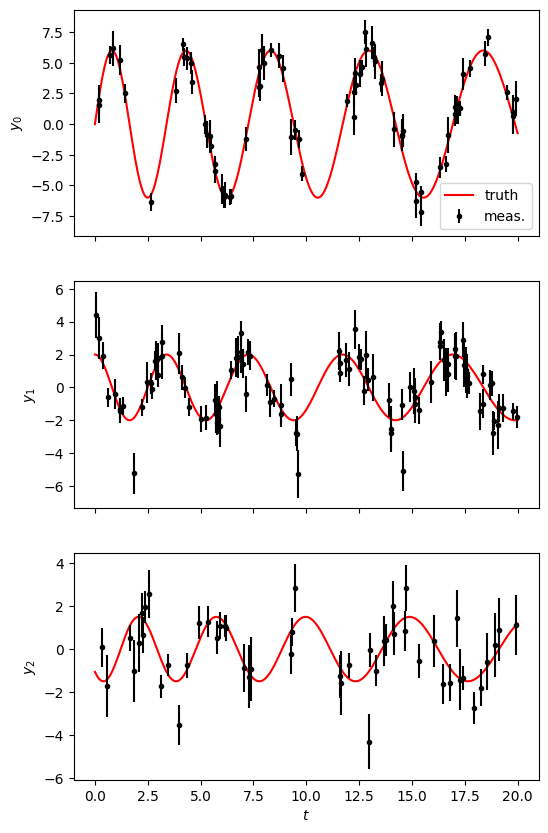

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Settings
P0 = 3.8
dP = 1.25
tmax = 20
amp = [6.0, 2.0, 1.5]
phase = [0, np.pi / 2, -3*np.pi / 4]
nt = [75, 100, 50]

# True signal
tsmooth = np.linspace(0, tmax, 400)
Psmooth = P0 + dP * (tsmooth / tmax - 1 / 2)
Ysignal = [
  ak * np.sin(2 * np.pi * tsmooth / Psmooth + pk)
  for ak, pk in zip(amp, phase)
]

# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 2,
  ntk // 2), np.random.uniform(2 * tmax / 3.5 , tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
P = [P0 + dP * (tk / tmax - 1 / 2) for tk in T]
Y = [
  amp[k] * np.sin(2 * np.pi * T[k] / P[k] + phase[k]) +
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

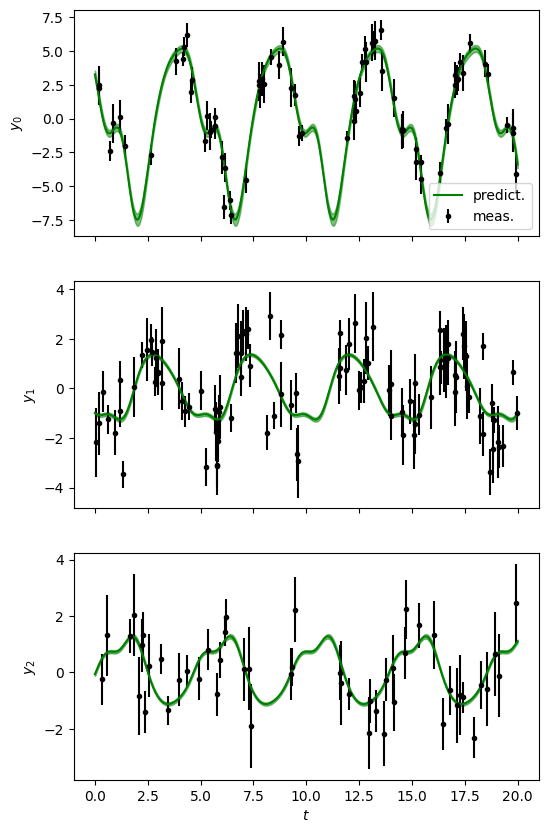

In [4]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)

# Initialize the S+LEAF model
C = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=4), series_index,
  [6.0, 2.0, 0.33], np.ones(3)))

D = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=4), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# List of parameters to fit
param = C.param[1:]
# The amplitude of the SHOKernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.

# Define the function to minimize
def negloglike(x, y, C):
  C.set_param(x, param)
  nll = -C.loglike(y)
  # gradient
  nll_grad = -C.loglike_grad()[1][1:]
  return (nll, nll_grad)

# Fit
xbest, _, _ = fmin_l_bfgs_b(negloglike, C.get_param(param), args=(y_full, C))

T_new = []
Y_new = []
C.set_param(xbest, param)

for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, T[k], calc_cov='diag')
  Y_new.append(np.random.normal(mu_fit, 1.0))
  

t_new, y_new, yerr_new, series_index = cov.merge_series(T, Y_new, Yerr)

# Fit
xbest, _, _ = fmin_l_bfgs_b(negloglike, C.get_param(param), args=(y_new, C))


# Use S+LEAF to predict the missing data
C.set_param(xbest, param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_new, tsmooth, calc_cov='diag')

  # Plot
  ax = axs[k]
  #ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y_new[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='g',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()





In [6]:
import sys
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
#from tinygp.helpers import JAXArray

if sys.version_info[1] < 10:
    raise Warning("You should be using Python 3.10 - tinygp may not work")

class LatentKernel(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return (
            a1 * a2 * K
            + a1 * b2 * dK_dx2
            + b1 * a2 * dK_dx1
            + b1 * b2 * d2K_dx1dx2
        )


def _build_tinygp_multidimensional(params):

    base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
            * kernels.ExpSineSquared(
            scale=jnp.abs(params["Prot"]),
            gamma=jnp.abs(params["gamma"]))

    kernel = LatentKernel(base_kernel, params['coeff_prime'], params['coeff_deriv'])
    return GaussianProcess(
        kernel, params['X'], diag=jnp.abs(params['diag']), mean=0.0
    )

@jax.jit
def _loss_tinygp(params):
    gp = _build_tinygp_multidimensional(params)
    return gp.log_probability(params['y'])

In [7]:

dataset_x0 = []
dataset_res = []
dataset_label = []
dataser_er2 = []

temp_input = []
temp_label = []

for ii in range(0, 3):
    temp_input = np.append(temp_input, tsmooth)
    temp_label = np.append(temp_label, np.zeros_like(tsmooth, dtype=int) + ii)

X_input = (temp_input, temp_label.astype(int))


for k in range(0,3):
    dataset_x0 = np.append(dataset_x0, T[k])
    dataset_label = np.append(dataset_label, np.zeros_like(T[k], dtype=int) + k)
    dataset_res = np.append(dataset_res, Y_new[k])
    dataser_er2 = np.append(dataser_er2, Yerr[k]**2)


tinygp_X = (dataset_x0, dataset_label.astype(int))

In [8]:
internal_parameter_values = xbest.copy()
theta_dict =  dict(
    gamma=1. / (2.*internal_parameter_values[2] ** 2),
    Pdec=internal_parameter_values[1],
    Prot=internal_parameter_values[0],
    diag=dataser_er2,
    X=tinygp_X,
    y=dataset_res,
    coeff_prime=internal_parameter_values[3:6],
    coeff_deriv=internal_parameter_values[6:],
    x_predict = X_input
)

gp = _build_tinygp_multidimensional(theta_dict)
_, cond_gp = gp.condition(theta_dict['y'], theta_dict['x_predict'])

#mu = cond_gp.mean
#std = np.sqrt(cond_gp.variance)
mu_full = cond_gp.loc # or cond_gp.mean?


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [11]:
internal_parameter_values = xbest.copy()
theta_dict =  dict(
    gamma=1. / (2.*internal_parameter_values[2] ** 2),
    Pdec=internal_parameter_values[1],
    Prot=internal_parameter_values[0],
    diag=dataser_er2,
    X=tinygp_X,
    y=dataset_res,
    coeff_prime=internal_parameter_values[3:6],
    coeff_deriv=internal_parameter_values[6:],
    x_predict = X_input
)

gp = _build_tinygp_multidimensional(theta_dict)
_, cond_gp_mod = gp.condition(theta_dict['y'], theta_dict['x_predict'])

#mu = cond_gp.mean
#std = np.sqrt(cond_gp.variance)
mu_full_mod = cond_gp_mod.loc # or cond_gp.mean?


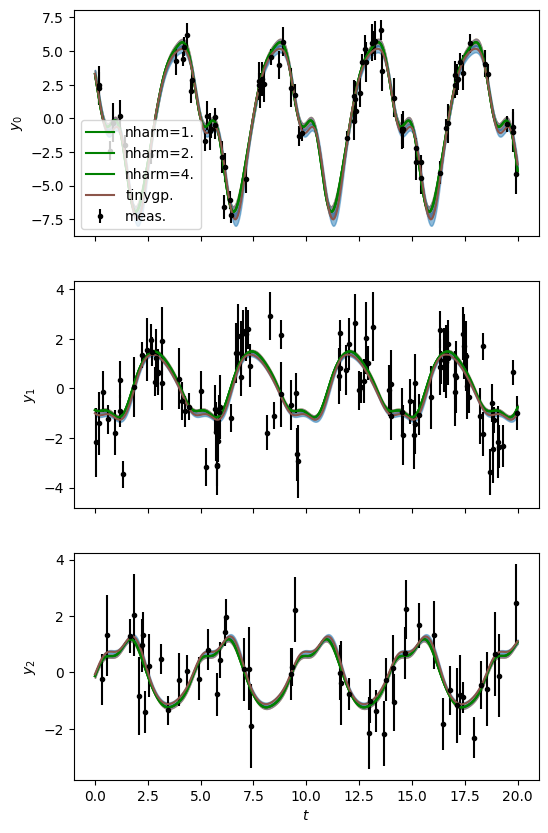

In [13]:
C1 = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=1), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C2 = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=2), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C3= cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=3), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C1.set_param(xbest, param)
C2.set_param(xbest, param)
C3.set_param(xbest, param)



_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))

for k in range(3):

  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  # Predict time series k
  l_nstart, l_nend = len(tsmooth)*k, len(tsmooth)*(k+1)

  tinygp_mu = mu_full[l_nstart:l_nend]
  tinygp_std = np.sqrt(cond_gp.variance)[l_nstart:l_nend]

  # Plot
  ax = axs[k]
  #ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y_new[k], Yerr[k], fmt='.', color='k', label='meas.')


  # Predict time series k
  C1.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C1',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=1.')  

  # Predict time series k
  C2.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C2',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=2.')  






  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C4',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=4.')  

  ax.fill_between(tsmooth,
    tinygp_mu - tinygp_std,
    tinygp_mu + tinygp_std,
    color='C0',
    alpha=0.5)
  ax.plot(tsmooth, tinygp_mu, 'C5', label='tinygp.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()

